# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

#DEP BELOW?
import matplotlib.pyplot as plt

In [2]:
#Extracted from Statcast

df = pd.read_csv('sea_p.csv')

In [3]:
df = df.sort_values(['game_date', 'at_bat_number', 'pitch_number'])

# Cleaning

In [4]:
dep_cols = df.nunique()[df.nunique() <= 1].index.tolist()

drop_cols = ['des','game_pk','pitcher.1','fielder_2','fielder_2.1','fielder_3','fielder_4','fielder_5','fielder_6',
             'fielder_7','fielder_8','fielder_9', 'pitch_type', 'home_score', 'away_score', 'post_away_score', 
             'post_home_score', 'batter', 'pitcher']

drop_cols += dep_cols

df.drop(drop_cols, axis = 1, inplace = True)

In [5]:
df.loc[df['on_3b'] > 0, 'on_3b'] = 1
df.loc[df['on_3b'] != 1, 'on_3b'] = 0

df.loc[df['on_2b'] > 0, 'on_2b'] = 1
df.loc[df['on_2b'] != 1, 'on_2b'] = 0

df.loc[df['on_1b'] > 0, 'on_1b'] = 1
df.loc[df['on_1b'] != 1, 'on_1b'] = 0

# Column Definitions + Useful Links

https://baseballsavant.mlb.com/csv-docs

https://www.mlb.com/glossary/statcast/

https://baseballsavant.mlb.com/statcast_search

# Player Filtering

In [6]:
df['player_name'].value_counts()

Gonzales, Marco       4829
Kikuchi, Yusei        3516
LeBlanc, Wade         2813
Leake, Mike           2783
Hernández, Félix      1813
Milone, Tommy         1750
Sheffield, Justus     1553
Elías, Roenis         1230
Swanson, Erik         1120
Dunn, Justin           937
Brennan, Brandon       842
Bass, Anthony          738
Gearrin, Cory          682
Margevicius, Nick      679
Ramírez, Erasmo        603
Festa, Matt            556
Magill, Matt           541
Altavilla, Dan         511
Adams, Austin          508
Grotz, Zac             501
Paxton, James          484
Bradford, Chasen       469
Walker, Taijuan        434
Sadzeck, Connor        424
Ramirez, Yohan         420
Tuivailala, Sam        415
Wisler, Matt           403
McClain, Reggie        354
Warren, Adam           353
Graveman, Kendall      329
Misiewicz, Anthony     328
Wright, Mike           313
Guilbeau, Taylor       311
Colomé, Alex           304
Díaz, Edwin            301
Vincent, Nick          300
Rosscup, Zac           293
A

In [7]:
player_name_is = 'Kikuchi, Yusei'

df = df[df['player_name'] == player_name_is]
df = df[df['game_year'] >= 2017]

# New Columns/Features

In [8]:
df['p_home'] = (df['inning_topbot'] == 'Top').astype(int)

df['p_throws_is_b_stands'] = (df['p_throws'] == df['stand']).astype(int)

df['new_bf'] = (df['pitch_number'] == 1).astype(int)

df['in_strike_zone'] = (df['zone'] < 10).astype(int)

df['count'] = df['balls'].astype(str) + "-" + df['strikes'].astype(str)

df['pitch_count_inning'] = df.groupby(by = ['game_date', 'player_name', 'inning'])['pitch_number'].cumcount() + 1

df['pitch_count_game'] = df.groupby(by = ['game_date', 'player_name'])['pitch_number'].cumcount() + 1

df['pitch_count_year'] = df.groupby(by = ['game_year', 'player_name'])['pitch_number'].cumcount() + 1

df['pitch_count_dataset'] = df.groupby(by = ['player_name'])['pitch_number'].cumcount() + 1

df['bf_game'] = (df.groupby(by = ['game_date', 'player_name'])['new_bf'].cumsum())

df['bf_inning'] = (df.groupby(by = ['game_date', 'player_name','inning'])['new_bf'].cumsum())

df['runners_on'] = (df['on_3b'] + df['on_2b'] + df['on_1b']).astype(int)

df['fld_score_up'] = df['fld_score'] - df['bat_score']

df['post_bat_score_delta'] = (df['post_bat_score'] - df['bat_score']).astype(int)

df.loc[(df['stand'] == 'L') & (df['zone'].isin([3,6,9,12,14])), 'pitch_inside'] = 1
df.loc[(df['stand'] == 'R') & (df['zone'].isin([1,4,7,11,13])), 'pitch_inside'] = 1

df.loc[(df['stand'] == 'L') & (df['zone'].isin([1,4,7,11,13])), 'pitch_outside'] = 1
df.loc[(df['stand'] == 'R') & (df['zone'].isin([3,6,9,12,14])), 'pitch_outside'] = 1

df.loc[df['zone'].isin([1,2,3,11,12]), 'pitch_up'] = 1
df.loc[df['zone'].isin([7,8,9,13,14]), 'pitch_down'] = 1

df['pitch_inside'].fillna(0, inplace = True)
df['pitch_outside'].fillna(0, inplace = True)
df['pitch_up'].fillna(0, inplace = True)
df['pitch_down'].fillna(0, inplace = True)

df.loc[(df['events'] == 'single'), 'SLG'] = 1
df.loc[(df['events'] == 'double'), 'SLG'] = 2
df.loc[(df['events'] == 'triple'), 'SLG'] = 3
df.loc[(df['events'] == 'home_run'), 'SLG'] = 4

slg_0 = ['field_out','strikeout','walk','force_out','grounded_into_double_play','hit_by_pitch','field_error','sac_fly',
        'fielders_choice','double_play','sac_bunt','fielders_choice_out','strikeout_double_play',
        'runner_double_play','sac_fly_double_play']

df.loc[(df['events'].isin(slg_0)), 'SLG'] = 0

obp_1 = ['single','double','triple','home_run','walk','hit_by_pitch']

df.loc[(df['events'].isin(obp_1)), 'OBP'] = 1

obp_0 = ['field_out','strikeout','force_out','grounded_into_double_play','field_error','sac_fly',
        'fielders_choice','double_play','sac_bunt','fielders_choice_out','strikeout_double_play',
        'runner_double_play','sac_fly_double_play']

df.loc[(df['events'].isin(obp_0)), 'OBP'] = 0

df['OPS'] = df['OBP'] + df['SLG']

# Other DFs

In [9]:
lhbdf = df[df['stand'] == 'L']
rhbdf = df[df['stand'] == 'R']

# Rename Columns

In [10]:
column_renames = {'type' : 'pitch_result', 'stand' : 'b_stands', 'pitch_number' : 'pitch_count_ab'}

df.rename(columns = column_renames, inplace = True)

# EDA

Text(0.5, 1.0, 'Batted Ball Type')

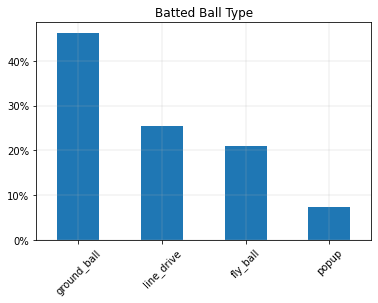

In [11]:
(df['bb_type'].value_counts(normalize = True)*100).plot(kind = 'bar', rot = 45).grid(linewidth = .25)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
plt.title('Batted Ball Type')

Text(0.5, 1.0, 'Pitch Usage')

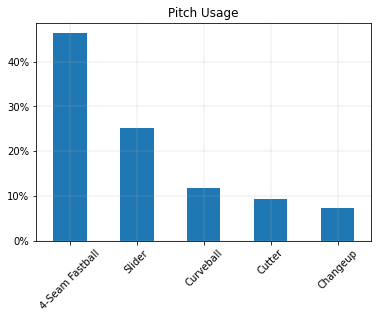

In [12]:
(df['pitch_name'].value_counts(normalize = True)*100).plot(kind = 'bar', rot = 45).grid(linewidth = .25)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
plt.title('Pitch Usage')

Text(0.5, 1.0, 'Count Distribution (excludes 0-0)')

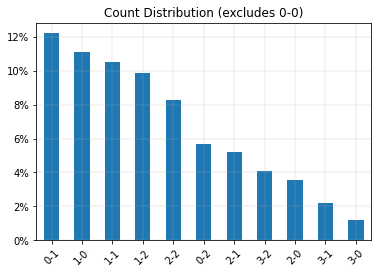

In [13]:
(df['count'].value_counts(normalize = True)*100)[1:].plot(kind = 'bar', rot = 45).grid(linewidth = .25)
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
plt.title('Count Distribution (excludes 0-0)')

Text(0, 0.5, '')

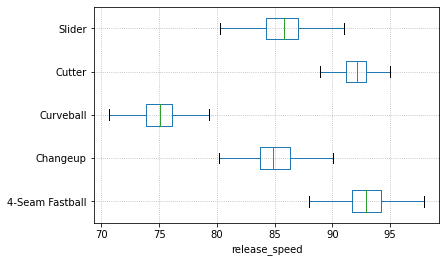

In [14]:
df.boxplot(column = ['release_speed'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')

plt.suptitle("")
plt.title("")
plt.xlabel("release_speed")
plt.ylabel("")

Text(0, 0.5, '')

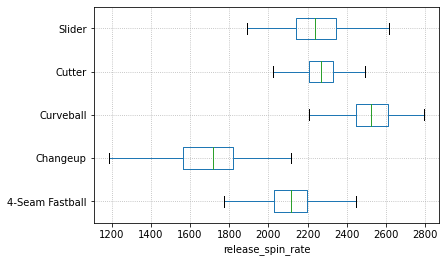

In [15]:
df.boxplot(column = ['release_spin_rate'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')
plt.suptitle("")
plt.title("")
plt.xlabel("release_spin_rate")
plt.ylabel("")

Text(0, 0.5, '')

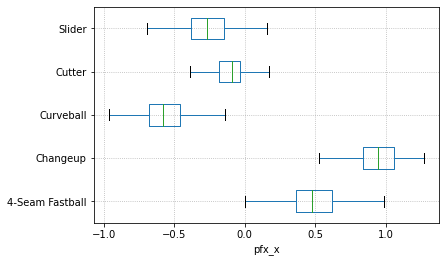

In [16]:
df.boxplot(column = ['pfx_x'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')
plt.suptitle("")
plt.title("")
plt.xlabel("pfx_x")
plt.ylabel("")

Text(0, 0.5, '')

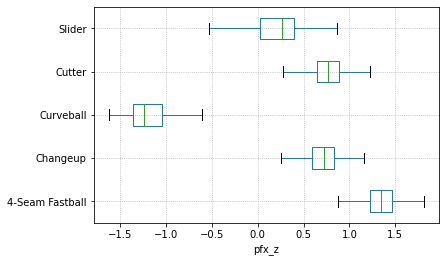

In [17]:
df.boxplot(column = ['pfx_z'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')
plt.suptitle("")
plt.title("")
plt.xlabel("pfx_z")
plt.ylabel("")

Text(0, 0.5, '')

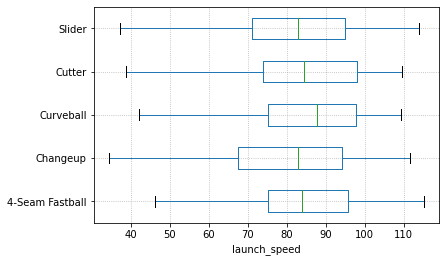

In [18]:
df.boxplot(column = ['launch_speed'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')
plt.suptitle("")
plt.title("")
plt.xlabel("launch_speed")
plt.ylabel("")

Text(0, 0.5, '')

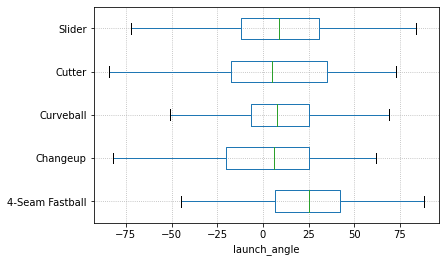

In [19]:
df.boxplot(column = ['launch_angle'], by = 'pitch_name', grid = True, rot = 0, vert = False, 
           showfliers = False).grid(linestyle = 'dotted')
plt.suptitle("")
plt.title("")
plt.xlabel("launch_angle")
plt.ylabel("")

In [20]:
pbyip_piv = pd.pivot_table(df[~df['pitch_name'].isnull()].filter(['player_name','pitch_name','inning']),
                           index = 'pitch_name', columns = 'inning', 
                           aggfunc = 'count').fillna(0).reset_index()

pbyip_piv.columns = ['inning','1','2','3','4','5','6','7','8','9']

for i in pbyip_piv.columns[1:]:
    pbyip_piv[i] = pbyip_piv[i].astype(int)

pbyip_piv.style.background_gradient(cmap='Wistia')

,inning,1,2,3,4,5,6,7,8,9
0,4-Seam Fastball,365,337,286,252,201,104,28,6,8
1,Changeup,26,47,48,63,40,12,10,4,0
2,Curveball,82,87,82,61,51,28,9,5,1
3,Cutter,44,72,64,68,30,40,0,0,0
4,Slider,169,167,170,166,99,60,22,7,3


In [21]:
count_freq = df['count'].value_counts().index.tolist()

pitch_name_by_count_order = ['pitch_name','All'] + count_freq

rhb_pitch_name_by_count = pd.pivot_table(rhbdf, index = ['pitch_name'], columns = ['count'],values = 'player_name', 
               aggfunc = 'count', margins = True).fillna(0)

rhb_pitch_name_by_count = rhb_pitch_name_by_count[:-1]

print('')
print('RHBs: Pitch Name % of Pitches by Count')
((rhb_pitch_name_by_count / rhb_pitch_name_by_count.sum()) 
 * 100).astype(int).reset_index().filter(pitch_name_by_count_order).style.background_gradient(cmap='Wistia')


RHBs: Pitch Name % of Pitches by Count


count,pitch_name,All,0-0,0-1,1-0,1-1,1-2,2-2,0-2,2-1,3-2,2-0,3-1,3-0
0,4-Seam Fastball,45,52,42,51,44,36,36,35,36,27,58,53,77
1,Changeup,9,7,27,1,8,11,7,15,2,1,1,0,0
2,Curveball,13,24,9,13,15,6,11,4,7,2,3,0,0
3,Cutter,8,3,3,11,7,7,9,6,12,22,23,20,22
4,Slider,24,11,17,22,24,38,35,37,40,45,13,26,0


In [22]:
pitch_name_by_count_order = ['pitch_name','All'] + count_freq

In [23]:
rhb_pitch_name_by_count = pd.pivot_table(rhbdf, index = ['pitch_name'], columns = ['count'],values = 'player_name', 
               aggfunc = 'count', margins = True).fillna(0)

rhb_pitch_name_by_count = rhb_pitch_name_by_count[:-1]

print('')
print('RHBs: Pitch Name % of Pitches by Count')
((rhb_pitch_name_by_count / rhb_pitch_name_by_count.sum()) 
 * 100).astype(int).reset_index().filter(pitch_name_by_count_order).style.background_gradient(cmap='Wistia')


RHBs: Pitch Name % of Pitches by Count


count,pitch_name,All,0-0,0-1,1-0,1-1,1-2,2-2,0-2,2-1,3-2,2-0,3-1,3-0
0,4-Seam Fastball,45,52,42,51,44,36,36,35,36,27,58,53,77
1,Changeup,9,7,27,1,8,11,7,15,2,1,1,0,0
2,Curveball,13,24,9,13,15,6,11,4,7,2,3,0,0
3,Cutter,8,3,3,11,7,7,9,6,12,22,23,20,22
4,Slider,24,11,17,22,24,38,35,37,40,45,13,26,0


In [24]:
lhb_pitch_name_by_count = pd.pivot_table(lhbdf, index = ['pitch_name'], columns = ['count'],values = 'player_name', 
               aggfunc = 'count', margins = True).fillna(0)

lhb_pitch_name_by_count = lhb_pitch_name_by_count[:-1]

print('')
print('LHBs: Pitch Name % of Pitches by Count')
((lhb_pitch_name_by_count / lhb_pitch_name_by_count.sum()) 
 * 100).astype(int).reset_index().filter(pitch_name_by_count_order).style.background_gradient(cmap='Wistia')


LHBs: Pitch Name % of Pitches by Count


count,pitch_name,All,0-0,0-1,1-0,1-1,1-2,2-2,0-2,2-1,3-2,2-0,3-1,3-0
0,4-Seam Fastball,50,54,44,46,45,50,50,46,53,44,55,80,90
1,Changeup,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Curveball,7,17,6,2,5,5,1,3,2,0,0,0,0
3,Cutter,12,7,5,18,12,10,15,9,19,32,25,20,10
4,Slider,29,20,45,32,36,32,32,40,24,24,18,0,0


In [25]:
pitch_name_by_count = pd.pivot_table(df, index = ['pitch_name'], columns = ['count'],values = 'player_name', 
               aggfunc = 'count', margins = True).fillna(0)

pitch_name_by_count = pitch_name_by_count[:-1]

print('')
print('Pitch Name % of Pitches by Count')
((pitch_name_by_count / pitch_name_by_count.sum()) 
 * 100).astype(int).reset_index().filter(pitch_name_by_count_order).style.background_gradient(cmap='Wistia')


Pitch Name % of Pitches by Count


count,pitch_name,All,0-0,0-1,1-0,1-1,1-2,2-2,0-2,2-1,3-2,2-0,3-1,3-0
0,4-Seam Fastball,46,53,43,50,44,39,38,37,40,30,58,58,80
1,Changeup,7,6,20,1,6,8,6,12,2,1,0,0,0
2,Curveball,11,22,8,11,13,6,9,4,6,2,2,0,0
3,Cutter,9,4,3,12,8,8,10,7,14,24,23,20,19
4,Slider,25,13,23,24,26,36,34,37,36,41,14,21,0


In [26]:
player_pitch_ops = pd.pivot_table(df, index = ['player_name','pitch_name'], values = ['OPS','release_speed'], 
                                  aggfunc = ['count','mean']).reset_index()

player_pitch_ops.columns = (['player_name', 'pitch_name', 'OPS count', 'pitch count', 'OPS mean', 'release_speed mean'])

player_pitch_ops[player_pitch_ops['pitch count'] > 100].sort_values('OPS mean', ascending = True)

,player_name,pitch_name,OPS count,pitch count,OPS mean,release_speed mean
1,"Kikuchi, Yusei",Changeup,67,250,0.567164,84.942800
3,"Kikuchi, Yusei",Cutter,96,318,0.656250,92.081447
4,"Kikuchi, Yusei",Slider,285,863,0.740351,85.570568
0,"Kikuchi, Yusei",4-Seam Fastball,376,1587,0.906915,92.932829
2,"Kikuchi, Yusei",Curveball,71,406,0.971831,75.001478


In [27]:
print('At Bat Results')
df['events'].value_counts(normalize = True)

At Bat Results


field_out                    0.412022
strikeout                    0.178142
single                       0.150820
walk                         0.076503
double                       0.056831
home_run                     0.042623
grounded_into_double_play    0.025137
force_out                    0.020765
field_error                  0.008743
sac_fly                      0.007650
triple                       0.007650
hit_by_pitch                 0.006557
fielders_choice              0.002186
double_play                  0.002186
fielders_choice_out          0.001093
batter_interference          0.001093
Name: events, dtype: float64

In [28]:
print('Pitch Results')
df['description'].value_counts(normalize = True)

Pitch Results


ball                       0.335893
hit_into_play              0.192264
foul                       0.175199
called_strike              0.160125
swinging_strike            0.088737
blocked_ball               0.027304
foul_tip                   0.009386
swinging_strike_blocked    0.006826
foul_bunt                  0.002275
hit_by_pitch               0.001706
pitchout                   0.000284
Name: description, dtype: float64

# Work-In-Progress Graphs

Text(0, 0.5, 'Avg. OPS')

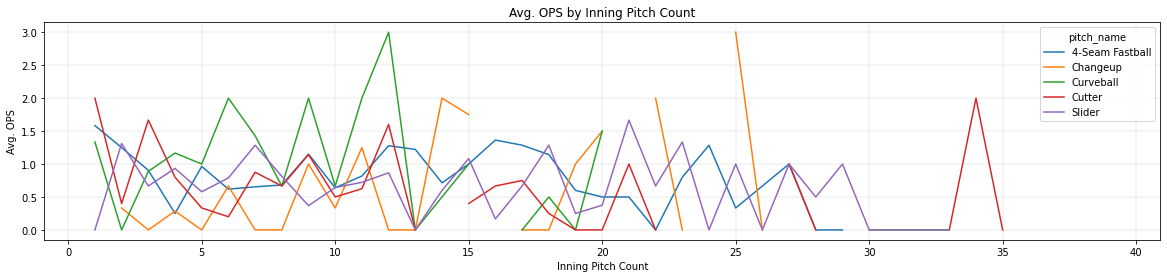

In [29]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'OPS', aggfunc = 'mean').plot(kind = 'line', figsize = (20,4)).grid(linewidth = .25)
plt.title('Avg. OPS by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Avg. OPS')

Text(0, 0.5, 'Horizontal Feet Movement (Catcher View)')

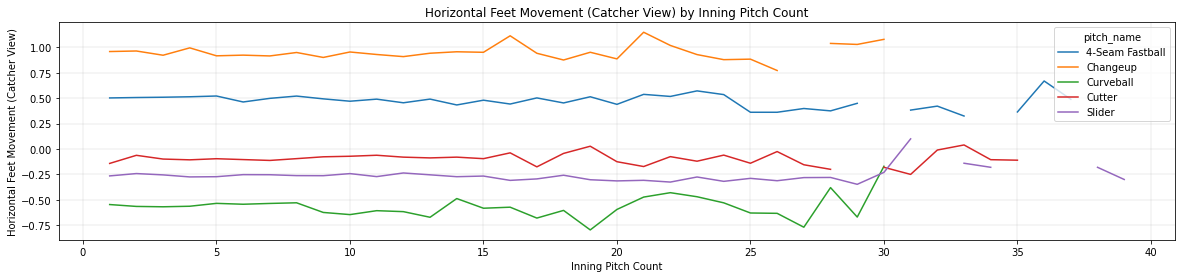

In [30]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'pfx_x', aggfunc = 'mean').plot(kind = 'line', figsize = (20,4)).grid(linewidth = .25)
plt.title('Horizontal Feet Movement (Catcher View) by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Horizontal Feet Movement (Catcher View)')

Text(0, 0.5, 'Vertical Feet Movement (Catcher View)')

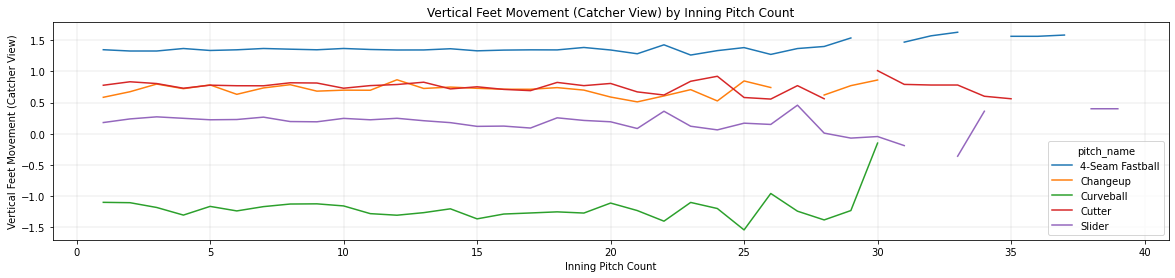

In [31]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'pfx_z', aggfunc = 'mean').plot(kind = 'line', figsize = (20,4)).grid(linewidth = .25)
plt.title('Vertical Feet Movement (Catcher View) by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Vertical Feet Movement (Catcher View)')

Text(0, 0.5, 'Pitch Release Speed')

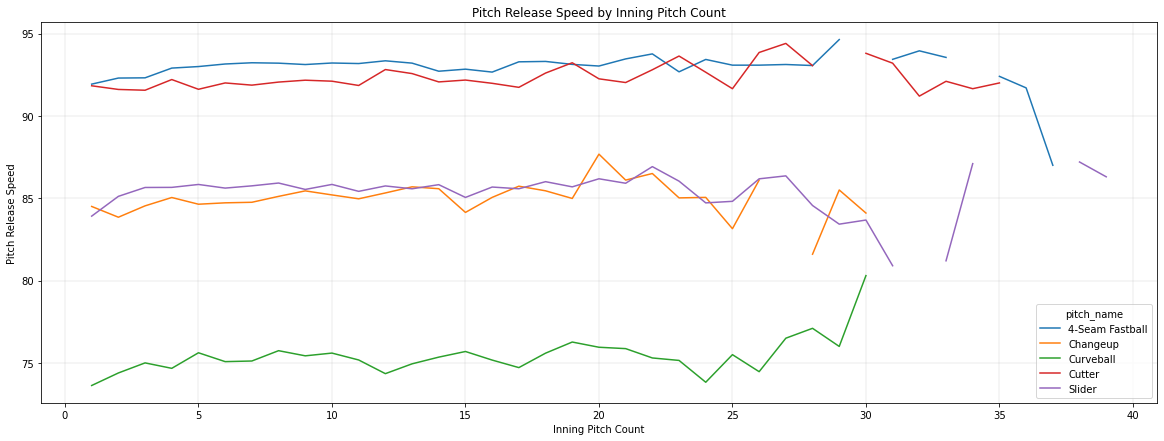

In [32]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'release_speed', aggfunc = 'mean').plot(kind = 'line', figsize = (20,7)).grid(linewidth = .25)
plt.title('Pitch Release Speed by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Pitch Release Speed')

Text(0, 0.5, 'Horizontal Feet Movement (Catcher View)')

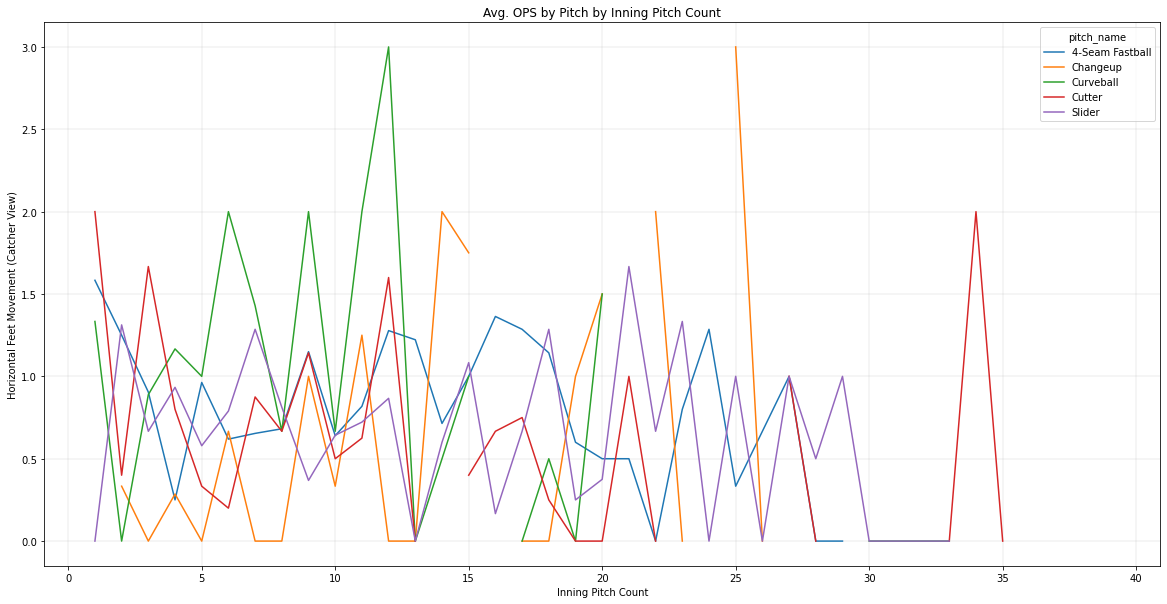

In [33]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'OPS', aggfunc = 'mean').plot(kind = 'line', figsize = (20,10)).grid(linewidth = .25)
plt.title('Avg. OPS by Pitch by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Horizontal Feet Movement (Catcher View)')

Text(0, 0.5, 'Pitch Release Spin Rate')

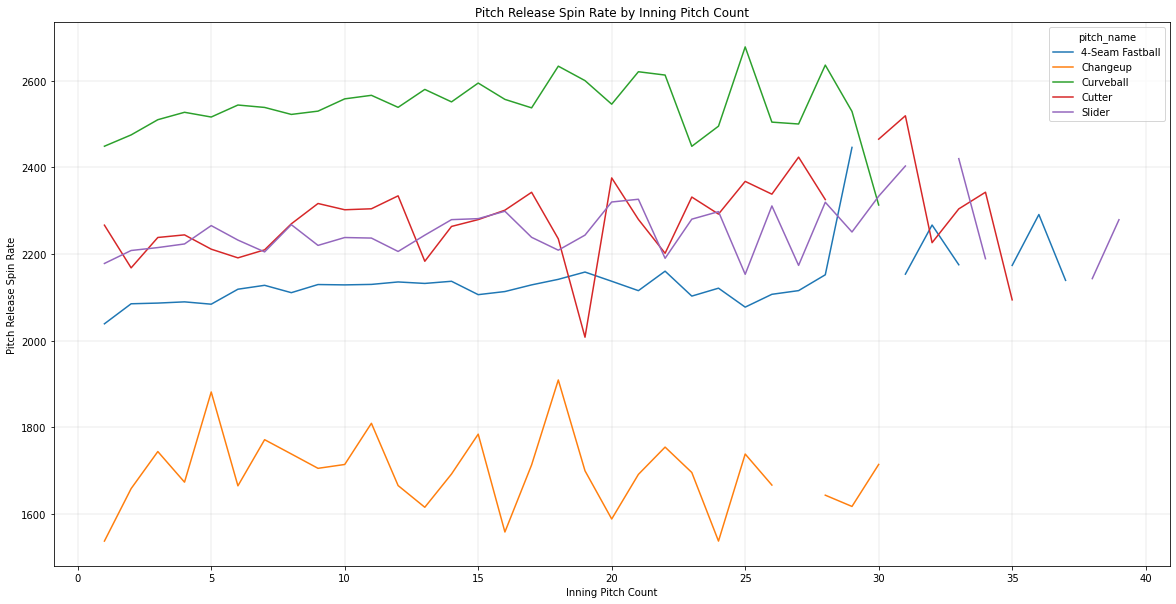

In [34]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = ['pitch_count_inning'], columns = 'pitch_name', 
               values = 'release_spin_rate', aggfunc = 'mean').plot(kind = 'line', figsize = (20,10)).grid(linewidth = .25)
plt.title('Pitch Release Spin Rate by Inning Pitch Count')
plt.xlabel('Inning Pitch Count')
plt.ylabel('Pitch Release Spin Rate')

Text(0.5, 0, '# Batter Faced In Game')

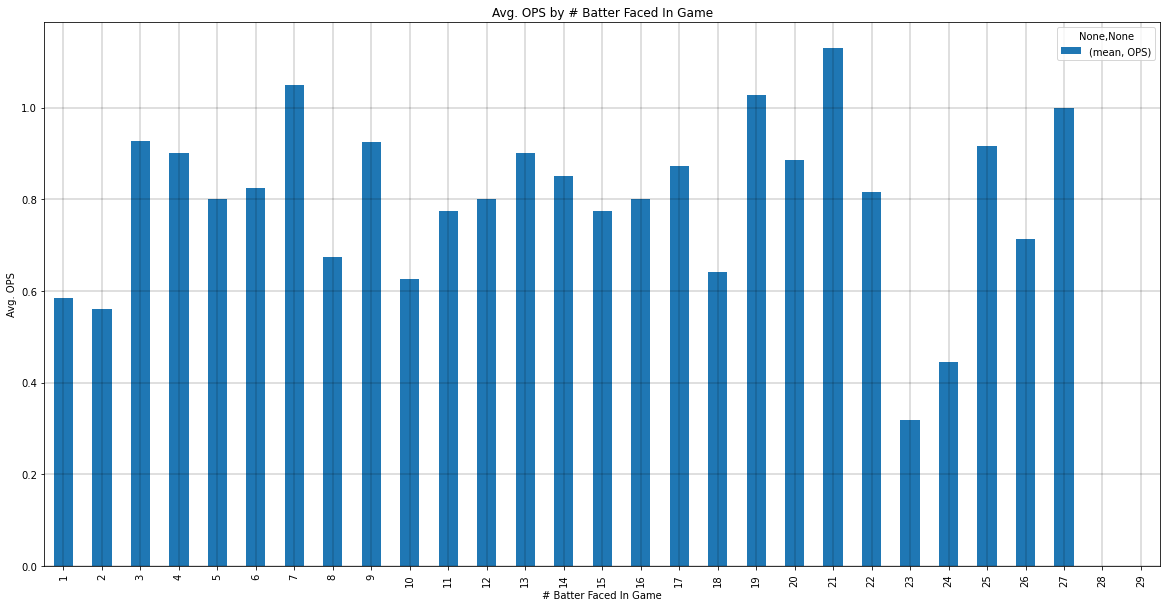

In [35]:
pd.pivot_table(df[df['player_name'] == player_name_is], index = 'bf_game', values = 'OPS', 
               aggfunc = ['mean']).plot(kind = 'bar', figsize = (20,10)).grid(linewidth = .25, color = 'k')
plt.title('Avg. OPS by # Batter Faced In Game')
plt.ylabel('Avg. OPS')
plt.xlabel('# Batter Faced In Game')
# box plots per x axis unit